# PROACT Dataset

In [6]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from utility.survival import make_time_bins
from SurvivalEVAL.Evaluations.util import KaplanMeier

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed.csv'), index_col=0)
df = df.loc[(df['TTE_Speech'] > 0) & (df['TTE_Swallowing'] > 0)
            & (df['TTE_Handwriting'] > 0) & (df['TTE_Walking'] > 0)
            & (df['TTE_Death'] > 0)] # min time
df = df.loc[(df['TTE_Speech'] <= 1000) & (df['TTE_Swallowing'] <= 1000)
            & (df['TTE_Handwriting'] <= 1000) & (df['TTE_Walking'] <= 1000)
            & (df['TTE_Death'] <= 1000)] # 5 years max
event_cols = ['Speech', 'Swallowing', 'Handwriting', 'Walking', 'Death']

# Rename columns for readability
df = df.rename({"Event_Speech": "Speech",
                "Event_Swallowing": "Swallowing",
                "Event_Handwriting": "Handwriting",
                "Event_Walking": "Walking",
                'Event_Death': "Death"}, axis=1)

In [7]:
# Print statistics on people that don't experience death event
df['Time_in_study'] = df.apply(lambda x: max(x['TTE_Speech'],  x['TTE_Swallowing'],
                                             x['TTE_Handwriting'], x['TTE_Walking'],
                                             x['TTE_Death']), axis=1)
df['SOO_Limb'] = df['Site_of_Onset'].apply(lambda x: 1 if x in ["Limb", "LimbAndBulbar"] else 0)
df['SOO_Bulbar'] = df['Site_of_Onset'].apply(lambda x: 1 if x in ["Bulbar", "LimbAndBulbar"] else 0)
df['SOO_Other'] = df['Site_of_Onset'].apply(lambda x: 1 if x in ["Other"] else 0)

num_features = ['Age', 'Height', 'Weight', 'ALSFRS_R_Total', 'Time_in_study']
cat_features = ['Sex', 'Race_Caucasian', 'SOO_Limb', 'SOO_Bulbar', 'SOO_Spine', 'Subject_used_Riluzole']
df_no_deaths = df.loc[df['Death'] == 0]
df_deaths = df.loc[df['Death'] == 1]

print(f'N no_deaths: {df_no_deaths.shape[0]} - N deaths: {df_deaths.shape[0]}')

for col in num_features:
    mean_no_deaths = df_no_deaths[col].astype(float).mean(axis=0).round(1)
    mean_deaths = df_deaths[col].astype(float).mean(axis=0).round(1)
    std_no_deaths = df_no_deaths[col].astype(float).std(axis=0).round(1)
    std_deaths = df_deaths[col].astype(float).std(axis=0).round(1)
    
    text_no_deaths = mean_no_deaths.astype(str) + " (" + std_no_deaths.astype(str) + ")"
    text_deaths = mean_deaths.astype(str) + " (" + std_deaths.astype(str) + ")"
    print(f"{col} (event): {text_no_deaths} - {col} (death): {text_deaths}")

print()
for data in [df_no_deaths, df_deaths]:
    print(f"Percentage of female: {data['Sex'].value_counts(normalize=True)['Female'] * 100:.1f}%")
    print(f"Percentage of Caucasian: {data['Race_Caucasian'].value_counts(normalize=True)[1.0] * 100:.1f}%")
    print(f"Percentage of SOO_Limb: {data['SOO_Limb'].value_counts(normalize=True)[1] * 100:.1f}%")
    print(f"Percentage of SOO_Bulbar: {data['SOO_Bulbar'].value_counts(normalize=True)[1] * 100:.1f}%")
    print(f"Percentage of SOO_Other: {data['SOO_Other'].value_counts(normalize=True)[1] * 100:.1f}%")
    print(f"Percentage of Subject_used_Riluzole: {data['Subject_used_Riluzole'].value_counts(normalize=True)['Yes'] * 100:.1f}%")
    print()

N no_deaths: 4442 - N deaths: 1287
Age (event): 55.1 (11.8) - Age (death): 60.2 (10.1)
Height (event): 160.6 (40.6) - Height (death): 168.9 (18.7)
Weight (event): 75.7 (15.6) - Weight (death): 69.2 (12.3)
ALSFRS_R_Total (event): 38.0 (5.4) - ALSFRS_R_Total (death): 36.0 (5.4)
Time_in_study (event): 326.4 (169.5) - Time_in_study (death): 340.7 (187.7)

Percentage of female: 36.7%
Percentage of Caucasian: 92.9%
Percentage of SOO_Limb: 35.4%
Percentage of SOO_Bulbar: 9.7%
Percentage of SOO_Other: 6.2%
Percentage of Subject_used_Riluzole: 87.0%

Percentage of female: 37.6%
Percentage of Caucasian: 94.8%
Percentage of SOO_Limb: 38.2%
Percentage of SOO_Bulbar: 13.3%
Percentage of SOO_Other: 6.1%
Percentage of Subject_used_Riluzole: 80.0%



In [8]:
# Load dataset for modeling
df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed.csv'), index_col=0)
df = df.loc[(df['TTE_Speech'] > 0) & (df['TTE_Swallowing'] > 0)
            & (df['TTE_Handwriting'] > 0) & (df['TTE_Walking'] > 0)] # min time
df = df.loc[(df['TTE_Speech'] <= 1000) & (df['TTE_Swallowing'] <= 1000)
            & (df['TTE_Handwriting'] <= 1000) & (df['TTE_Walking'] <= 1000)]
event_cols = ['Speech', 'Swallowing', 'Handwriting', 'Walking']

# Rename columns for readability
df = df.rename({"Event_Speech": "Speech",
                "Event_Swallowing": "Swallowing",
                "Event_Handwriting": "Handwriting",
                "Event_Walking": "Walking"}, axis=1)

# Drop rows with no handgrip strength test
df = df.dropna(subset='Handgrip_Strength')

# Print event distribution ['Speech', 'Swallowing', 'Handwriting', 'Walking']
for event_col in event_cols:
    obs_arr = np.array(df[event_col])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round((obs_arr.shape[0]-n_censored) / obs_arr.shape[0] * 100, 2)}% of records are uncensored\n")

Number of samples: 1206
Number of censored/uncensored: 879/327
27.11% of records are uncensored

Number of samples: 1206
Number of censored/uncensored: 969/237
19.65% of records are uncensored

Number of samples: 1206
Number of censored/uncensored: 892/314
26.04% of records are uncensored

Number of samples: 1206
Number of censored/uncensored: 585/621
51.49% of records are uncensored



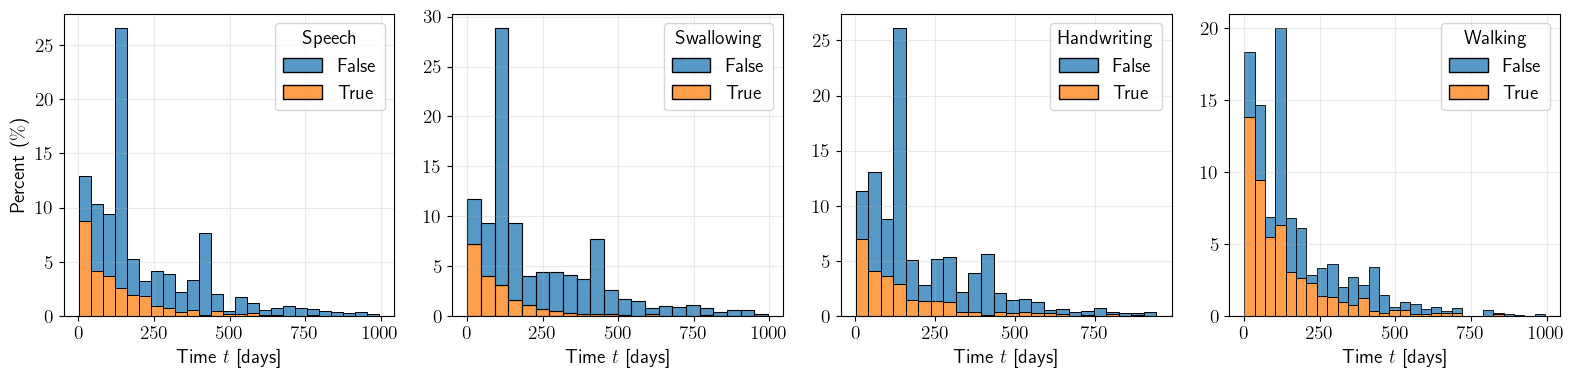

In [9]:
# Plot event distribution
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))  # Adjust the figure width for 4 plots
axs = axs.flatten()
for i, col in enumerate(event_cols):
    event = df[[f'TTE_{col}', f'{col}']]  # Assuming 'df' is defined elsewhere
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'{col}', multiple="stack", bins="auto", ax=axs[i], stat="percent")
    axs[i].set_xlabel("Time $t$ [days]")
    if i == 0:
        axs[i].set_ylabel("Percent ($\%$)")
    else:
        axs[i].set_ylabel("")
    axs[i].grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/proact_event_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

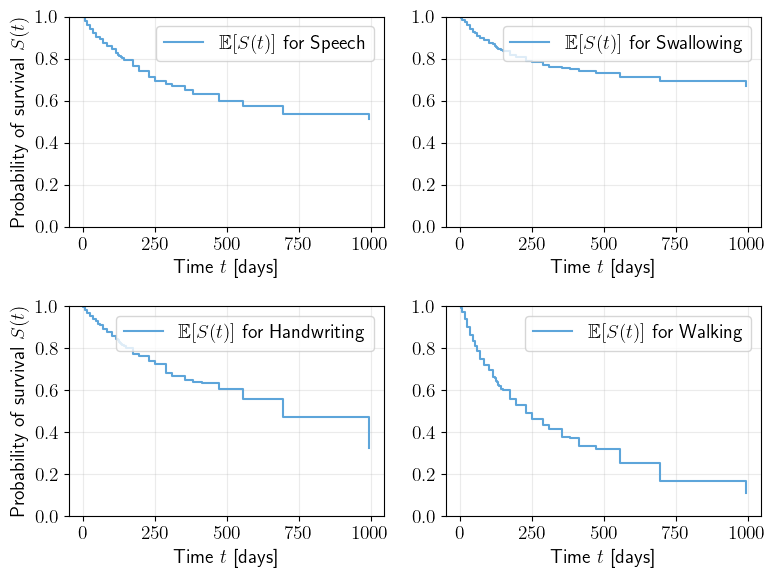

In [10]:
# Plot KM curves
event_times = df[['TTE_Speech', 'TTE_Swallowing', 'TTE_Handwriting', 'TTE_Walking']].to_numpy()
event_indicators = df[['Speech', 'Swallowing', 'Handwriting', 'Walking']].to_numpy()

time_bins = make_time_bins(event_times, event=None)
time_bins = torch.cat((torch.tensor([0]), time_bins))

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for event_id in range(4): # 4 events
    times = event_times[:, event_id]
    indicators = event_indicators[:, event_id]
    
    km_model = KaplanMeier(times, indicators)
    km_surv_prob = torch.from_numpy(km_model.predict(time_bins)).numpy()
    
    # Plotting the survival curve
    axes[event_id].step(time_bins.numpy(), km_surv_prob, where='post',
                        label=r"$\mathbb{E}[S(t)]$ for" + f" {event_cols[event_id]}", color=TFColor[3])
    #axes[event_id].set_title(f'KM Curve for {event_cols[event_id]}')
    axes[event_id].set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        axes[event_id].set_ylabel("Probability of survival $S(t)$")
    axes[event_id].set_ylim(0, 1)
    axes[event_id].legend(loc='upper right')
    axes[event_id].grid(True, alpha=0.25)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/proact_km_curves.pdf", format='pdf', bbox_inches='tight')
plt.show()